# **THỰC HÀNH PYTHON: REAL ESTATE PRICE PREDICTION_2002-01-26** 


Bài thực hành sử dụng nguồn dữ liệu từ Kaggle có tên Real estate price prediction 

Link: https://www.kaggle.com/quantbruce/real-estate-price-prediction?select=Real+estate.csv

*Ghi chú: Bài thực hành này chỉ mang tính tham khảo chưa đề cập đến một số các vấn đề khác như các biến có liên quan tương tác - interaction effects, phi tuyến tính, các yếu tố gây nhiễu Confounder, collider, Covariate ...*

## **A. KHẢO SÁT VÀ THĂM DÒ DỮ LIỆU** 

Khai báo các thư viện cần thiết cho việc thăm dò và phân tích 

In [ ]:
!pip install pandas-profiling==2.7.1

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [143]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV

import pandas_profiling as pp
import pandas_profiling
from pandas_profiling import ProfileReport

import folium
from folium import Choropleth, Circle, Marker 
from folium.plugins import HeatMap, MarkerCluster 

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

import pylab

from scipy.stats import shapiro, normaltest, anderson, kstest, skew, kurtosis
import scipy.stats as stats

Tải tập dữ liệu  

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Data Sample/Real estate.csv')

**Thăm dò dữ liệu**

Trong bài thực hành này mình sẽ dùng package folium trong python để thể hiện trực quan vị trí tọa lạc của các bất động sản. Vi trí là một trong những yếu tố quan trọng cấu thành nên giá giao dịch BĐS




In [8]:
city_map = folium.Map(location = [24.98, 121.52], 
                  tiles='Stamen Terrain', 
                  zoom_start=12)

folium.TileLayer('Stamen Terrain').add_to(city_map)
folium.TileLayer('Stamen Toner').add_to(city_map)
folium.TileLayer('Stamen Water Color').add_to(city_map)
folium.TileLayer('cartodbpositron').add_to(city_map)
folium.TileLayer('cartodbdark_matter').add_to(city_map)
folium.LayerControl().add_to(city_map)

for i in range (0, len(df)):
  lat = df["X5 latitude"][i]
  long = df["X6 longitude"][i]
  folium.Marker(
      [lat, long], ).add_to(city_map)

city_map


In [9]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [10]:
df.shape

(414, 8)

Dữ liệu này có 414 dòng và 8 cột, tên các biến như sau: 

In [11]:
[_ for _ in df.columns]

['No',
 'X1 transaction date',
 'X2 house age',
 'X3 distance to the nearest MRT station',
 'X4 number of convenience stores',
 'X5 latitude',
 'X6 longitude',
 'Y house price of unit area']

In [12]:
df.info() # Thông tin kiểu dữ liệu 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [13]:
df.isnull().sum() # Kiểm tra Missing Values

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

In [14]:
df.drop('No', 
        axis = 1, 
        inplace = True) # Xóa bỏ cột STT

Tính các chỉ số thống kê mô tả tổng quát: count, max-min, mean, std, quantiles ... 

In [15]:
df.describe()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


Thống kê mô tả tập dữ liệu bằng cách sử dụng pandas profiling report, cách làm này chỉ mang tính thống kê mô tả tổng quát 

In [16]:
pp.ProfileReport(df) 

Output hidden; open in https://colab.research.google.com to view.

Khảo sát đặc tính phân bố dữ liệu thông qua biểu đồ trực quan hóa KDE 

In [17]:
xy_vars = ['X1 transaction date', 
           'X2 house age',
           'X3 distance to the nearest MRT station',
           'X4 number of convenience stores', 
           'Y house price of unit area' ]

bin_pals = ['#1278e6','#e61244']

In [23]:
def multiple_kde_plot(data: pd.DataFrame,
                      feats: list):
    
    plt.rcParams["figure.figsize"] = (13,8)
    plt.rcParams.update({'font.size': 10})
    
    fig, axes = plt.subplots(nrows=2, ncols=3, dpi = 90)
    fig.subplots_adjust(hspace=0.7)
    
    fig.suptitle(f'Đặc tính phân bố của {len(feats)} biến')
    
    for ax,feature in zip(axes.flatten(), feats):
        
        lim = data[feature].min(), data[feature].max()
            
        sns.kdeplot(data = df[feature],
                    shade = True,
                    clip = lim,
                    alpha = 0.3,
                    ax = ax)
        
        sns.rugplot(data = df[feature],
                    alpha = 0.4,
                    ax = ax)
        
    axes.flatten()[1].legend(loc='center', bbox_to_anchor=(0.5,1.25), ncol=2)
    
    plt.tight_layout()
    plt.show()

No handles with labels found to put in legend.


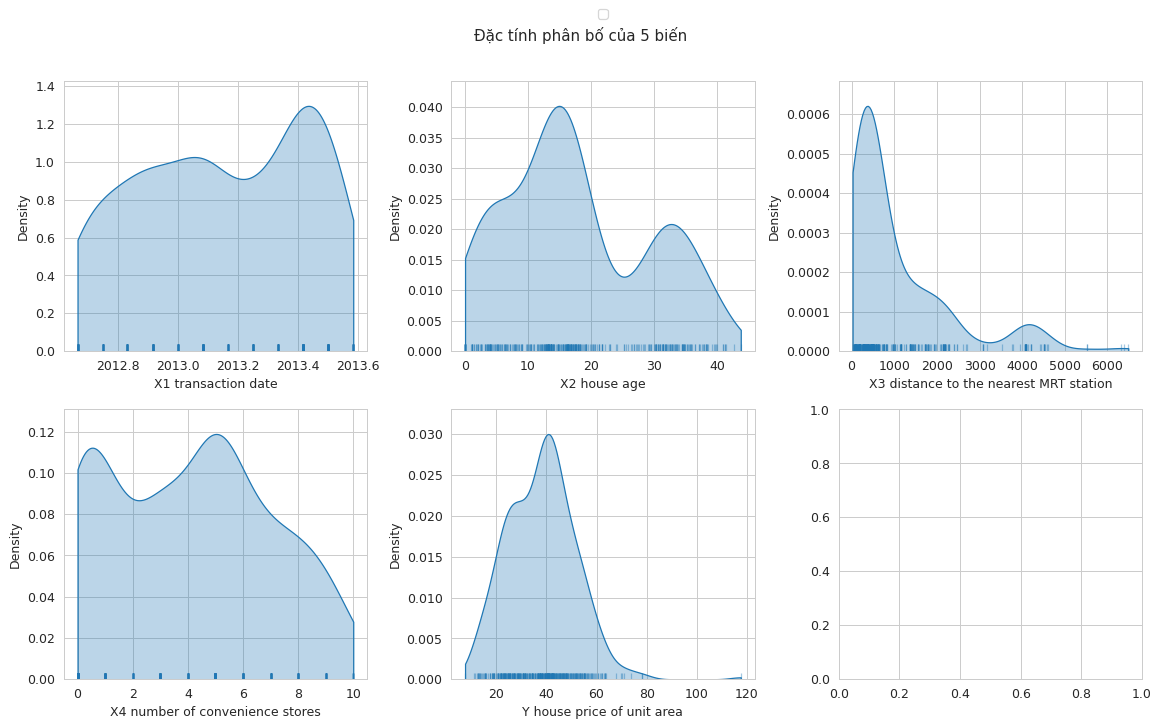

In [24]:
multiple_kde_plot(data = df,
             feats = xy_vars)

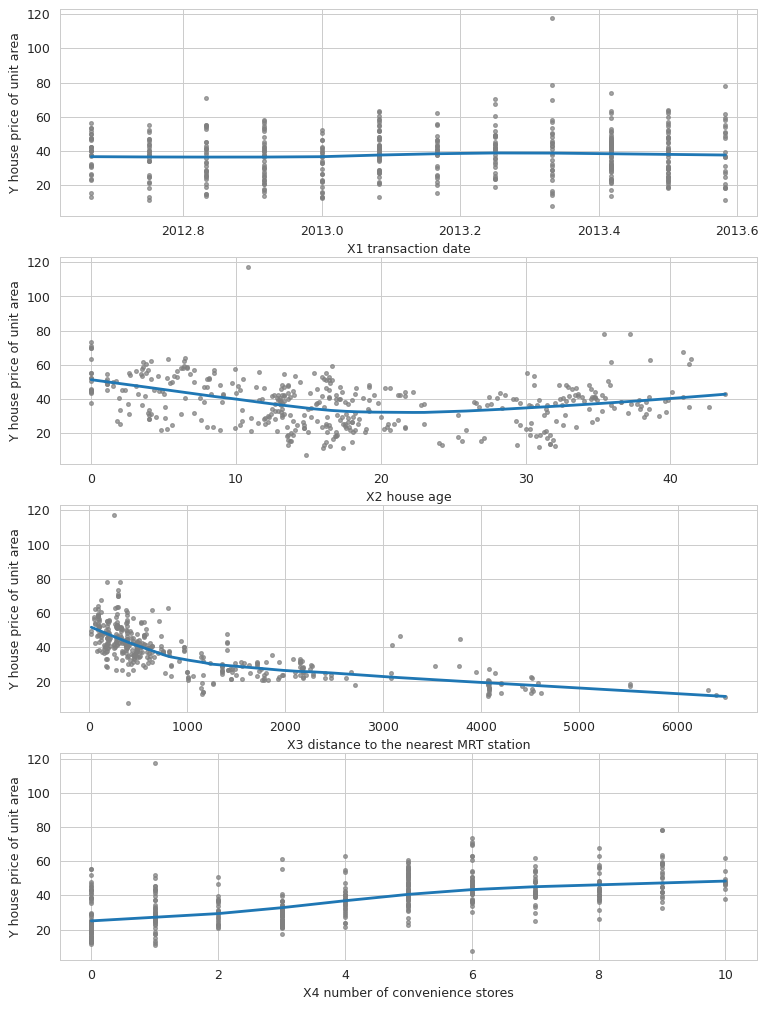

In [25]:
y_vars = 'Y house price of unit area'

x_vars = ['X1 transaction date', 
          'X2 house age', 
          'X3 distance to the nearest MRT station',
          'X4 number of convenience stores']

fig, axs = plt.subplots(nrows=len(x_vars), 
                        figsize=(10,14), 
                        dpi = 90)

for i, v in enumerate(x_vars):
    g = sns.regplot(x = df[v].values, 
                y = df[y_vars].values,
                lowess = True, 
                    marker = ".",
                scatter_kws={'alpha':0.7, 'color':'grey'},
                ax = axs[i])
    g.set(xlabel=v, ylabel=y_vars)

Xem xét mối tương quan giữa các biến số (correlation) và hiện tượng đa cộng tuyến (multicollinearity) 

In [40]:
cor = df.corr(method='spearman')

cor_target = abs(cor['Y house price of unit area'])
cor_target

X1 transaction date                       0.066928
X2 house age                              0.281753
X3 distance to the nearest MRT station    0.775948
X4 number of convenience stores           0.617333
X5 latitude                               0.578419
X6 longitude                              0.437672
Y house price of unit area                1.000000
Name: Y house price of unit area, dtype: float64

Text(0.5, 1.0, 'Correlation Heatmap (Target/Outcome & Feature)')

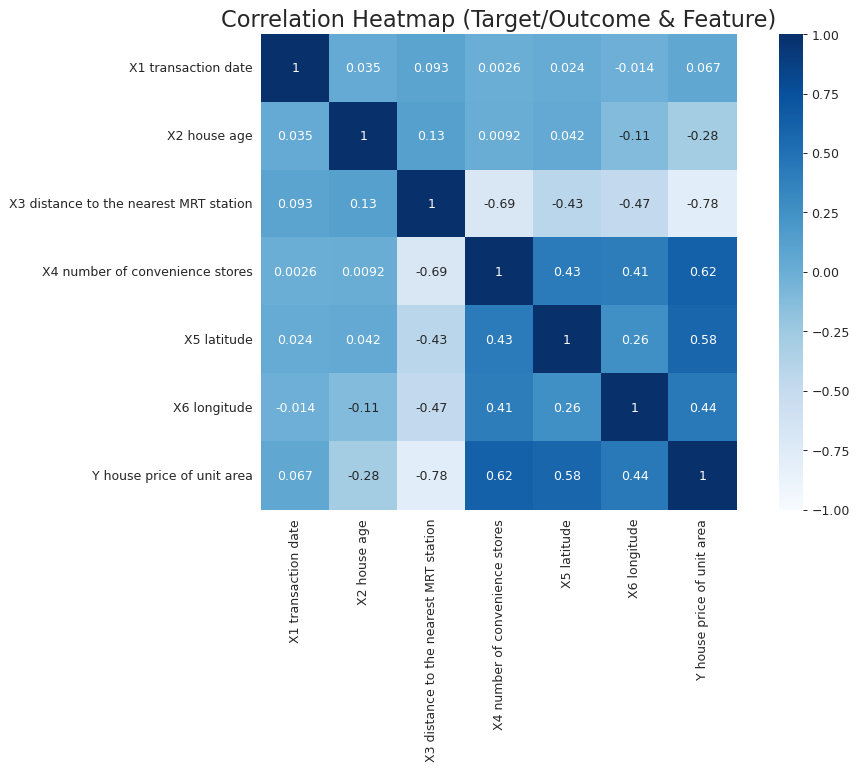

In [30]:
plt.figure(figsize=(12,7), 
           dpi = 90)

corr = df.corr(method='spearman') 

heat_map_corr = sns.heatmap(corr,
            vmin = -1, 
            vmax = 1,
            square = True,
            cmap = 'Blues', 
            annot=True)

heat_map_corr.set_title('Correlation Heatmap (Target/Outcome & Feature)', 
                   fontdict={'fontsize':18}
                   )

Text(0.5, 1.0, 'Correlation Heatmap (Feature/Predictor)')

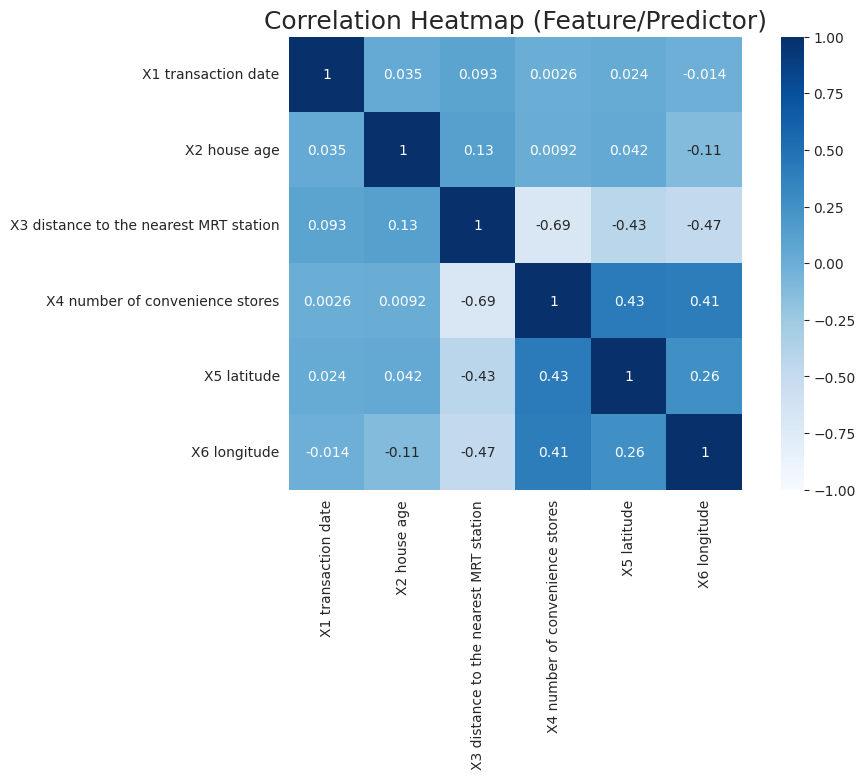

In [31]:
plt.figure(figsize=(10,6), 
           dpi = 100)

corr = df.iloc[:,0:6].corr(method='spearman') 

heat_map_corr = sns.heatmap(corr,
            vmin = -1, 
            vmax = 1,
            square = True,
            cmap = 'Blues', 
            annot=True)

heat_map_corr.set_title('Correlation Heatmap (Feature/Predictor)', 
                   fontdict={'fontsize':18}
                   )

Đa cộng tuyến thường xảy ra khi 2 biến hay hơn 2 biến tiên lượng có liên quan mật thiết với nhau. Thông thường hệ số tương quan giữa 2 biến tiên lượng có giá trị càng cao cần chú ý đến vấn đề đa cộng tuyến cơ cấu, ảnh hưởng hay làm giảm độ chính xác (precision) của tham số và giảm độ chính xác của tiên lượng (predicted value). Dùng phương pháp tính chỉ số lạm phát phương sai - VIF (Variance Inflation Factor). Công thức đơn giản hóa VIF: 

### <center> $VIF = \frac{1}{1-R_k^2}$ <center/>

Trong đó $R_k^2$ là hệ số xác định của mô hình với biến $x_k$. Theo quy ước chung, bất cứ biến tiên lượng nào có trị số VIF trên 5 (có khi trên 10) được xem là hiện tượng đa cộng tuyến. Ở bước này mình sẽ thăm dò hiện tượng đa cộng tuyến. Việc sử dụng phương pháp điều chuẩn Ridge và Lasso ở phần sau sẽ khắc phục được đa cộng tuyến. Dưới đây là chỉ số VIF


In [36]:
X_VIF = df[['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']]

vif_df = pd.DataFrame()

vif_df["feature"] = X_VIF.columns
vif_df["VIF"] = [variance_inflation_factor(X_VIF.values, i) for i in range(len(X_VIF.columns))]

print(vif_df)

                                  feature           VIF
0                     X1 transaction date  4.253389e+07
1                            X2 house age  3.471392e+00
2  X3 distance to the nearest MRT station  4.261358e+00
3         X4 number of convenience stores  4.748152e+00
4                             X5 latitude  6.178301e+06
5                            X6 longitude  4.198817e+07


## **B. XÂY DỰNG MÔ HÌNH: POLYNOMIAL REGRESSION - SỬ DỤNG PHƯƠNG PHÁP ĐIỀU CHUẨN REGULARIZATION RIDGE, LASSO VÀ ELASTIC NET**



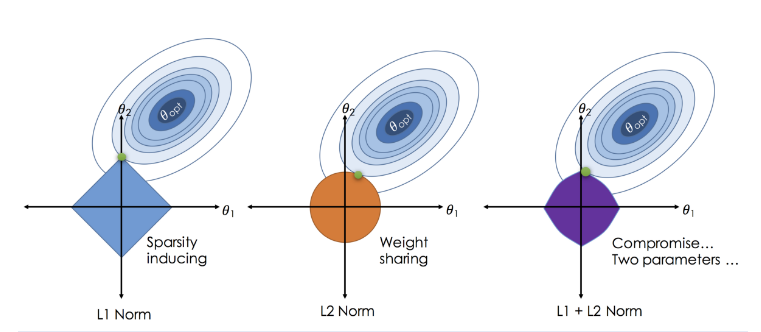



*An image visualising how ordinary regression compares to the Lasso, the Ridge and the Elastic Net Regressors. Image Citation: Zou, H., & Hastie, T. (2005). Regularization and variable selection via the elastic net.*


In [41]:
#Tách 2 tập dữ liệu X, Y gồm features và target 
X = df.drop('Y house price of unit area', axis=1)
Y = df['Y house price of unit area']

Ta thử thực hiện với mô hình Linear Regression, khả năng cao sẽ gặp vấn đề overfitting (quá khớp) - High Bias (độ lệch cao) và High Variance (phương sai cao) lúc này giá trị dự báo hay tiên lượng sẽ dao động qua lại xung quanh giá trị quan sát. Điều này thể hiện qua gia tăng chỉ số MSE (Mean Squared Erro). 

Phương pháp "least squares" bình phương tối thiếu được xem là phương pháp chuẩn để ước tính tham số trong mô hình hồi quy trong điều kiện các biến tiên lượng độc lập không liên quan với nhau, tuy nhiên trong trường hợp này với nhiều biến tiên lượng dẫn đến phương sai cao vì vậy mô hình hồi quy tuyến tính không còn khả dĩ trong trường hợp này để cho ra ước số khách quan (unbiased)

In [162]:
XS_train, XS_test, YS_train, YS_test = train_test_split(X, Y, 
                                                        test_size=0.3, 
                                                        random_state = 101)

LM = LinearRegression()
LM.fit(XS_train, YS_train)
YS_pred = LM.predict(XS_test)

MAE_LM = mean_absolute_error(YS_test, YS_pred)
MSE_LM = mean_squared_error(YS_test, YS_pred)
RMSE_LM = np.sqrt(MSE_LM)

pd.DataFrame([MAE_LM, MSE_LM, RMSE_LM], index=['MAE_LM', 'MSE_LM', 'RMSE_LM'], columns=['Metrics'])

,Metrics
MAE_LM,5.392294
MSE_LM,46.211798
RMSE_LM,6.797926


In [106]:
pd.DataFrame(LM.coef_ , X.columns, columns=["Coeficients"])

,Coeficients
X1 transaction date,4.839261
X2 house age,-0.274749
X3 distance to the nearest MRT station,-0.004189
X4 number of convenience stores,1.181231
X5 latitude,242.384317
X6 longitude,23.399135


Mô hình có tính bất định thể hiện qua giá trị MSE cao


In [66]:
pd.DataFrame({'YS_Test': YS_test,'YS_Pred':YS_pred, 'Residuals':(YS_test-YS_pred) }).head(5)

,YS_Test,YS_Pred,Residuals
176,19.2,12.638304,6.561696
347,11.2,10.030446,1.169554
307,24.7,22.988074,1.711926
299,46.1,48.502648,-2.402648
391,31.3,32.671405,-1.371405


In [108]:
Test_Residuals_LM = YS_test - YS_pred

In [124]:
class Gaussian_Dist_Check: 
  '''Class kiểm tra giả định phân bố Chuẩn của 1 biến X
  @Args: x = pandas series
  '''

  def __init__(self, x):
    self.x = x 
  
  def describe(self, percentiles = [0.25, 0.5, 0.75]): 
    '''Thống kê mô tả
    @Argument: percentiles(list, float)
    @Output: pandas series gồm size, mean, sd, các percentiles, skewness, kurtosis
    '''
    p = self.x.describe(percentiles = percentiles)
    sk = pd.Series([skew(self.x), kurtosis(self.x)], index = ['Skew', 'Kurto'])

    return p.append(sk)
  
  def QQ_plot(self): 
    ''' Vẽ biểu đồ QQPlot
    '''
    qqplot(self.x, line='s')
  
  def Dist_plot(self, kde = True, rug = True):
    ''' Vẽ histogram và KDE Plot
    '''

    sns.distplot(self.x, 
                 kde = kde,
                 rug = rug,
                 hist_kws = {'color':'blue'},
                 kde_kws = {'color': 'red'},
                 rug_kws = {'color': 'darkred'}
                 )
    
  def Shapiro_Wilk (self, alpha = 0.05): 
    '''Kiểm định Shapiro_Wilk
    @arguments: alpha = 0.05
    '''

    stat, s = shapiro(self.x)
    shapiro_int = 'Không thể phủ định H0, phân phối gần với phân phối Chuẩn' if s > alpha \
    else 'Phủ định H0, phân phối không phải phân phối Chuẩn'
    print(f'Kết quả kiểm định Shapiro-Wilk: stat={stat}, s={s}')
    print(shapiro_int)
    
  def DAgostino(self, alpha = 0.05): 
    '''Kiểm định D'Agostino
    @ argument:
    alpha = 0.05
    ''' 
    stat, p = normaltest(self.x)

    agos_int = 'Không thể phủ định H0, phân phối gần với Gaussian' if p > alpha \
    else 'Phủ định H0, phân bố không phải Gaussian'
    print(f'Kết quả kiểm định D\'Agostino: K2={stat}, p ={p}')
    print(agos_int)

  def Anderson_Darling(self):
        '''Kiểm định Anderson Darling
        '''
        out = anderson(self.x, dist='norm')
        
        H0 = []

        for i in range(len(out.critical_values)):
            H0.append('No' if out.statistic < out.critical_values[i] else 'Yes')
        
        print(f'Kết quả kiểm định Anderson Darling: stat = {out.statistic}')
        
        return pd.DataFrame({'Critical_vals':  out.critical_values,
                             'Critical_levels': [str(int(sl))+'%' for sl in out.significance_level],
                             'H0 Rejected': H0,
                            })



In [127]:
Epsilon_check = Gaussian_Dist_Check(Test_Residuals_LM)

Epsilon_check.describe()

count    125.000000
mean      -1.406326
std        6.677632
min      -18.419346
25%       -5.756049
50%       -2.426754
75%        1.936300
max       23.218058
Skew       0.734315
Kurto      1.165327
dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


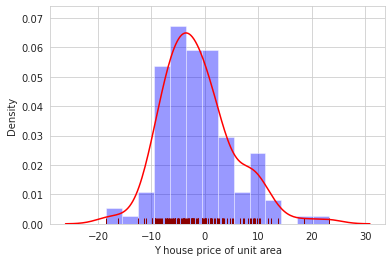

In [125]:
Epsilon_check.Dist_plot()

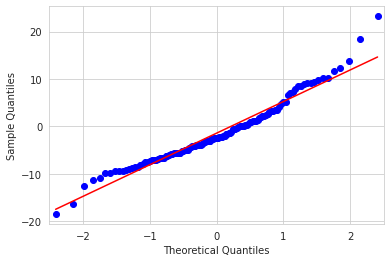

In [123]:
Epsilon_check.QQ_plot()

In [183]:
Epsilon_check.Shapiro_Wilk()

Kết quả kiểm định Shapiro-Wilk: stat=0.9629530906677246, s=0.001685654278844595
Phủ định H0, phân phối không phải phân phối Chuẩn


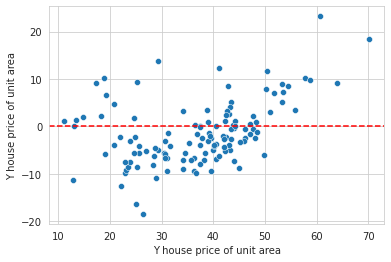

In [129]:
sns.scatterplot(x=YS_test, y=Test_Residuals_LM) 

plt.axhline(y=0, color='red', ls='--')

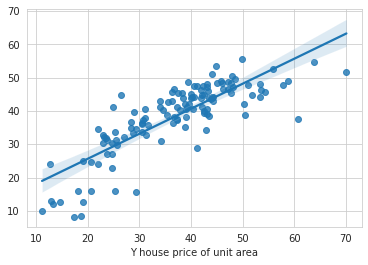

In [135]:
sns.regplot(x=YS_test, y=YS_pred)  

**Polynomial Regression Model**

In [59]:
#Tạo features bậc degree = 2 cho mô hình (hồi quy đa thức bậc 2)
PF = PolynomialFeatures(degree=2, 
                        include_bias=False)

poly_features = PF.fit_transform(X)

poly_features.shape

(414, 27)

In [43]:
#Chia dataset thành 2 tập train và test 
X_train, X_test, Y_train, Y_test = train_test_split(poly_features, 
                                                    Y, 
                                                    test_size = 0.3, 
                                                    random_state=101)

In [60]:
#Hoán chuyển dữ liệu (standardization) đưa về thang đo 0:1, áp dụng cho feature (X), cách làm này thay đổi thang đo, đơn vị đo, và đặc tính phân bố dữ liệu

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**1. Phương pháp Ridge Regression** *(L2 Penalty)*

Loss Function trong phương pháp Ridge Regression tìm ước số sao cho tổng bình phương phần dư (residuals) là thấp nhất và cộng thêm vào thành phần điều chuẩn (regularization term). Việc này giúp giật lùi ước số về gần hay hướng về 0. 

Đặc trưng của thành phần điều chuẩn là tham số $\lambda$ (ở nhiều tài liệu khác thể hiện $α$ ) bản chất đều là regularization penalty. Khi $λ$ = 0 thì ước số của ridge bằng với ước số của phương pháp bình phương tối thiểu. Khi $λ$ $ \mapsto ∞$ thì ước số của ridge tiệm cận 0, hay nói cách khác là thu hẹp ước số mô hình qua đó giảm bớt hiện tượng quá khớp (overfitting) 

In [176]:
ridge_model = Ridge(alpha = 0.5)
ridge_model.fit(X_train, Y_train)


Y_pred = ridge_model.predict(X_test) #Tiên lượng y_test sau khi training model

MAE = mean_absolute_error(Y_test, Y_pred) #mean absolute error - Trung bình sai biệt tuyệt đối 
MSE = mean_squared_error(Y_test, Y_pred) # Mean square erro - Trung bình bình phương sai số có thể xem là phương sai của y sau khi hiệu chỉnh cho x. Mô hình giải thích y càng tốt hiểu theo nghĩa giá trị tiên lượng Y_pred gần với giá trị quan sát) thì MSE càng thấp 
RMSE = np.sqrt(MSE) #root mean squared error - Căn bậc 2 của trung bình bình phương sai số

pd.DataFrame([MAE, MSE, RMSE], index=['MAE', 'MSE', 'RMSE'], columns = ['Metrics for Ridge alpha = 0.5'])

,Metrics for Ridge alpha = 0.5
MAE,4.365238
MSE,29.855336
RMSE,5.464004


**Sử dụng thuật toán K-fold validation** 




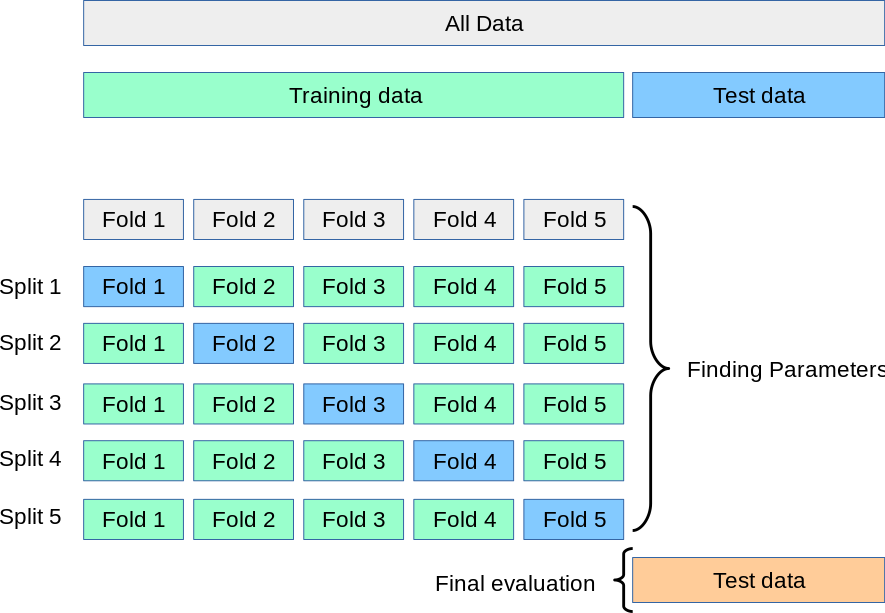

In [168]:
ridge_cv_model = RidgeCV(alphas=(0.1, 1.0, 10.0), 
                       scoring='neg_mean_absolute_error')
ridge_cv_model.fit(X_train, Y_train)
ridge_cv_model.alpha_

10.0

In [138]:
Y_pred_ridge = ridge_cv_model.predict(X_test)
MAE_ridge = mean_absolute_error(Y_test, Y_pred_ridge)
MSE_ridge = mean_squared_error(Y_test, Y_pred_ridge)
RMSE_ridge = np.sqrt(MSE_ridge)

pd.DataFrame([MAE_ridge, MSE_ridge, RMSE_ridge], index=['MAE', 'MSE', 'RMSE'], columns=['Metrics for Ridge alpha = 10'])

,Metrics for Ridge alpha = 10
MAE,4.391900
MSE,29.762841
RMSE,5.455533


In [139]:
ridge_cv_model.coef_

array([ 0.57875685, -2.36377567, -2.00820899,  1.04023218,  0.95215055,
       -0.38861754,  0.57930784, -2.36247422, -2.00960676,  1.04090716,
        1.05797324,  0.17214277,  5.45450981,  1.22591901,  1.10580855,
       -2.36626438, -2.36422608,  3.28822439, -2.81715017, -2.02863313,
       -2.0107962 , -0.88364658,  1.03938303,  1.04134392,  0.95015155,
        0.75650918, -0.38836498])

**2. Phương pháp LASSO Regression** *(L1 Penalty)*

Thay vì sử dụng norm chuẩn bậc 2 như phương pháp Ridge, phương pháp LASSO (least absolute shrinkage and selection operator) sử dụng norm chuẩn bậc 1. Hay nói cách khác Phương pháp Ridge 'phạt' cho tổng bình phương các ước số, còn LASSO 'phạt' trên tổng giá trị tuyệt đối của các ước số. 

Trong trường hợp tập dữ liệu có các biến đầu vào features là đa cộng tuyến mô hình hồi quy LASSO có xu hướng lựa chọn ra một biến trong nhómc ác biến đa cộng tuyến và bỏ qua các biến còn lại, đối với hồi quy Rigde và tuyến tính có xu hướng sử dụng tất cả các biến đầu vào. 



In [174]:
lasso_cv_model = LassoCV(eps=0.01, n_alphas=100, cv=5)
lasso_cv_model.fit(X_train, Y_train)

lasso_cv_model.alpha_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.949e+00, tolerance: 5.971e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


0.11393382171919163

In [175]:
Y_pred_lasso = lasso_cv_model.predict(X_test)

MAE_lasso = mean_absolute_error(Y_test, Y_pred_lasso)
MSE_lasso = mean_squared_error(Y_test, Y_pred_lasso)
RMSE_lasso = np.sqrt(MSE_lasso)

pd.DataFrame([MAE_lasso, MSE_lasso, RMSE_lasso], 
             index=['MAE', 'MSE', 'RMSE'], 
             columns=['Lasso Metrics'])

,Lasso Metrics
MAE,4.456687
MSE,30.770283
RMSE,5.547097


In [173]:
lasso_cv_model.coef_

array([ 0.34215602, -3.35640923, -6.15365165,  3.14852129,  0.        ,
       -0.        ,  0.14593652, -0.00715257, -0.92551495,  0.28540344,
        3.73285138,  0.        ,  6.53267819,  0.        ,  0.3094857 ,
       -6.25164592, -0.        ,  4.07101662, -2.3805771 , -0.49974234,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ])

**3. Elastic Net**

Combines both L1 and L2 regularization. Đây là sự kết hợp đồng thời cả hai thành phần điều chuẩn norm chuẩn bậc và norm chuẩn bậc 2 theo kết hợp tuyến tính lồi. 

In [182]:
Elastic_model = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], cv=5, max_iter=100000)
Elastic_model.fit(X_train, Y_train)
Elastic_model.l1_ratio_

0.5

In [178]:
Y_pred_Elastic = Elastic_model.predict(X_test)

In [179]:
MAE_Elastic = mean_absolute_error(Y_test, Y_pred_Elastic)
MSE_Elastic = mean_squared_error(Y_test, Y_pred_Elastic)
RMSE_Elastic = np.sqrt(MSE_Elastic)

pd.DataFrame([MAE_Elastic, MSE_Elastic, RMSE_Elastic], 
             index=['MAE', 'MSE', 'RMSE'], 
             columns = ['Metrics for ElasticCV l1=0.5'])

,Metrics for ElasticCV l1=0.5
MAE,4.376537
MSE,29.773343
RMSE,5.456496
